# Building Out Comparisons

Author: Jake Dumbauld <br>
Contact: jacobmilodumbauld@gmail.com<br>
Date: 3.15.22

In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import re
from IPython.display import clear_output
import gc

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import backend

In [17]:
root_path = '/Users/jmd/Documents/BOOTCAMP/Capstone'

In [7]:
n_trials = 30

Defining a Helper Function to Plot Confusion Matrix

In [2]:
def plot_CF(cf_matrix, title):
    """
    Takes an input confusion matrix as an NP array and returns a seaborn heatmap plot with labels.

    cf_matrix : confusion matrix as an np array
    title: title of the file & image. str.
    """
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(6,6))
    plt.title(title, size=14)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.savefig(root_path+'/confusion_matrices/' + title)

In [3]:
def record_accs(title, train_accs, val_accs, test_accs):
  """
  Takes a title and 3 lists of accuracies to save a csv of the accs.
  """

  df = pd.DataFrame(list(zip(train_accs, val_accs, test_accs)),
                    columns =['train_accs', 'val_accs', 'test_accs'])

  df.to_csv(((root_path + '/model_eval_csv/') + title) + '.csv', index=False)

Defining Function to Train Models Iteratively

In [4]:
def model_n_trials(n, config_path, initial_learning_rate):
    """
    Trains a keras model from a given architecture specified at the `config_path` n times. Tracks train_accs, val_accs, test_accs, and generates a running confusion matrix across all trials.
    
    n: number of times to train the model
    config_path: filepath to a saved neural network
    initial_learning_rate: initial learning rate for the model to be used in the lr_schedule.
    """
    
    #loading in optimal model configuration from my model search
    best_config = keras.models.load_model(config_path).get_config()

    #defining learning rate
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
                  #initial learning rate copied from model search.
                  initial_learning_rate=initial_learning_rate,
                  decay_steps=1.0,
                  decay_rate=0.1
    )

    #defining a blank confusion matrix to keep a running total
    final_cf = np.zeros((2,2), np.int32)
    #defining a lists for other metrics of interest
    train_accs = []
    val_accs = []
    test_accs = []

    for i in range(0,n):
        print("Trial " + str(i+1) + "/30 Begin")
        model = keras.Sequential.from_config(best_config)

        model.compile(
            #Optimizer
            optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
            #Loss
            loss=keras.losses.BinaryCrossentropy(),
            #Metrics
            metrics=[keras.metrics.BinaryAccuracy()]
        )
        #training model with an early stopping callback
        es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=(es_callback))

        #appending training accuracy
        train_accs.append(history.history["binary_accuracy"][-1])
        #appending validation accuracy
        val_accs.append(history.history["val_binary_accuracy"][-1])
        
        print("Evaluating Model " + str(i+1))
        
        #appending test accuracy
        test_accs.append(model.evaluate(X_test,y_test)[1])
        #adding running totals to the overall confusion matrix
        y_pred= (model.predict(X_test) > 0.5).astype("int32")
        cf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
        final_cf += cf_matrix

        #necessary to avoid memory issues from iteratively training kears models that I read about online.
        backend.clear_session()
        gc.collect()
        #clearing output text after each trial to avoid screen vomit
        clear_output(wait=True)
    
    return final_cf, train_accs, val_accs, test_accs

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importantly - NOT setting random seed here. I want to ensure that there is some randomness in the training process to demonstrate the robustness of my output models.

Defining the Model From the Best HPs found in Model Search

## Gathering Data

### 0 - Sequential Basline 4K No Pt

In [8]:
#loading in training data
raw = np.load(root_path + '/arrays/signal_murmur_presimple_4k.npy')

y = raw[:,0] #murmurs are just the first column
X = raw[:,1:]

#train test val split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
sequential_signal_4k_no_cf, sequential_signal_4k_no_train_accs, sequential_signal_4k_no_val_accs, sequential_signal_4k_no_test_accs = model_n_trials(n_trials, 
                                                                                                                                                     root_path + '/neural_nets/sequential_4k_signal_no_patient',
                                                                                                                                                     0.0011433841321939594)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 14ms/step - loss: 0.7716 - binary_accuracy: 0.7249 - val_loss: 0.7565 - val_binary_accuracy: 0.7896
Epoch 2/100
46/46 [==============================] - 0s 9ms/step - loss: 0.6493 - binary_accuracy: 0.8682 - val_loss: 0.7385 - val_binary_accuracy: 0.7911
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.5939 - binary_accuracy: 0.8879 - val_loss: 0.7275 - val_binary_accuracy: 0.7911
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.5580 - binary_accuracy: 0.8988 - val_loss: 0.7206 - val_binary_accuracy: 0.7927
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 0.5295 - binary_accuracy: 0.9076 - val_loss: 0.7150 - val_binary_accuracy: 0.7927
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: 0.5115 - binary_accuracy: 0.9090 - val_loss: 0.7108 - val_binary_accuracy: 0.7911
Epoch 7/100
46/46 [==============================] 

In [ ]:
plot_CF(sequential_signal_4k_no_cf, 'Sequential Model, 4k Signal, No Patient')
record_accs('Sequential Model, 4k Signal, No Patient', sequential_signal_4k_no_train_accs, sequential_signal_4k_no_val_accs, sequential_signal_4k_no_test_accs)

### 1 - Sequential Baseline 1K No Pt

In [10]:
X = np.load(root_path + '/arrays/signal_noPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

#train test val split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
sequential_signal_1k_no_cf, sequential_signal_1k_no_train_accs, sequential_signal_1k_no_val_accs, sequential_signal_1k_no_test_accs = model_n_trials(n_trials, 
                                                                                                                                                     root_path + '/neural_nets/sequential_signal_no_patient',
                                                                                                                                                     0.01)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 9ms/step - loss: 0.6068 - binary_accuracy: 0.7826 - val_loss: 0.5660 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5392 - binary_accuracy: 0.7948 - val_loss: 0.5508 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.4662 - binary_accuracy: 0.7948 - val_loss: 0.6714 - val_binary_accuracy: 0.7959
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.3247 - binary_accuracy: 0.8594 - val_loss: 0.9127 - val_binary_accuracy: 0.7073
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2534 - binary_accuracy: 0.9558 - val_loss: 1.0982 - val_binary_accuracy: 0.6930
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 0.2120 - binary_accuracy: 0.9728 - val_loss: 1.2018 - val_binary_accuracy: 0.6835
Epoch 7/100
46/46 [==============================] -

In [ ]:
plot_CF(sequential_signal_1k_no_cf, 'Sequential Model, 1k Signal, No Patient')
record_accs('Sequential Model, 1k Signal, No Patient', sequential_signal_1k_no_train_accs, sequential_signal_1k_no_val_accs, sequential_signal_1k_no_test_accs)

### 2- Sequential Baseline 1K with Pt

In [12]:
X = np.load(root_path + '/arrays/signal_withPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
sequential_signal_1k_w_cf, sequential_signal_1k_w_train_accs, sequential_signal_1k_w_val_accs, sequential_signal_1k_w_test_accs = model_n_trials(n_trials, 
                                                                                                                                                 root_path + '/neural_nets/sequential_signal_with_patient',
                                                                                                                                                 0.001230336587363103)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 17ms/step - loss: 18.1248 - binary_accuracy: 0.6787 - val_loss: 1.4557 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: 1.2634 - binary_accuracy: 0.6984 - val_loss: 0.6726 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: 0.8735 - binary_accuracy: 0.6692 - val_loss: 0.6072 - val_binary_accuracy: 0.7959
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: 0.8159 - binary_accuracy: 0.7004 - val_loss: 0.6489 - val_binary_accuracy: 0.7864
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: 0.6351 - binary_accuracy: 0.7683 - val_loss: 0.5986 - val_binary_accuracy: 0.7959
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.6597 - binary_accuracy: 0.7643 - val_loss: 0.5797 - val_binary_accuracy: 0.7959
Epoch 7/100
46/46 [==========================

In [ ]:
plot_CF(sequential_signal_1k_w_cf, 'Sequential Model, 1k Signal, With Patient')
record_accs('Sequential Model, 1k Signal, With Patient', sequential_signal_1k_w_train_accs, sequential_signal_1k_w_val_accs, sequential_signal_1k_w_test_accs)

### 3 - Sequential MFCC no Pt

In [14]:
X = np.load(root_path + '/arrays/MFCCs_noPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
sequential_MFCC_no_cf, sequential_MFCC_no_train_accs, sequential_MFCC_no_val_accs, sequential_MFCC_no_test_accs = model_n_trials(n_trials, 
                                                                                                                                 root_path + '/neural_nets/sequential_MFCCs_no_patient',
                                                                                                                                 0.01)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 8ms/step - loss: 0.6772 - binary_accuracy: 0.6997 - val_loss: 0.5967 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5567 - binary_accuracy: 0.7894 - val_loss: 0.5444 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5412 - binary_accuracy: 0.7908 - val_loss: 0.5360 - val_binary_accuracy: 0.7959
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.5335 - binary_accuracy: 0.7894 - val_loss: 0.5459 - val_binary_accuracy: 0.7959
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 0.5232 - binary_accuracy: 0.7948 - val_loss: 0.5271 - val_binary_accuracy: 0.7959
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5172 - binary_accuracy: 0.7935 - val_loss: 0.5508 - val_binary_accuracy: 0.7991
Epoch 7/100
46/46 [==============================] -

In [ ]:
plot_CF(sequential_MFCC_no_cf, 'Sequential Model, MFCCs, No Patient')
record_accs('Sequential Model, MFCCs, No Patient', sequential_MFCC_no_train_accs, sequential_MFCC_no_val_accs, sequential_MFCC_no_test_accs)

### 4 - Sequential MFCC with Pt

In [16]:
X = np.load(root_path + '/arrays/MFCCs_withPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
sequential_MFCC_w_cf, sequential_MFCC_w_train_accs, sequential_MFCC_w_val_accs, sequential_MFCC_w_test_accs = model_n_trials(n_trials, 
                                                                                                                             root_path + '/neural_nets/sequential_MFCCs_with_patient',
                                                                                                                             0.01)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 8ms/step - loss: 0.6228 - binary_accuracy: 0.7935 - val_loss: 0.8443 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.5483 - binary_accuracy: 0.8077 - val_loss: 0.5657 - val_binary_accuracy: 0.8133
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5246 - binary_accuracy: 0.8200 - val_loss: 0.5453 - val_binary_accuracy: 0.8101
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.4971 - binary_accuracy: 0.8281 - val_loss: 0.5790 - val_binary_accuracy: 0.8180
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.4820 - binary_accuracy: 0.8288 - val_loss: 0.6134 - val_binary_accuracy: 0.8101
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.4773 - binary_accuracy: 0.8152 - val_loss: 0.6407 - val_binary_accuracy: 0.8085
Epoch 7/100
46/46 [==============================] -

In [ ]:
plot_CF(sequential_MFCC_w_cf, 'Sequential Model, MFCCs, With Patient')
record_accs('Sequential Model, MFCCs, With Patient', sequential_MFCC_w_train_accs, sequential_MFCC_w_val_accs, sequential_MFCC_w_test_accs)

### 5 - CNN MFCC no Pt

In [18]:
X = np.load(root_path + '/arrays/MFCCs_noPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
CNN_MFCC_no_cf, CNN_MFCC_no_train_accs, CNN_MFCC_no_val_accs, CNN_MFCC_no_test_accs = model_n_trials(n_trials, 
                                                                                                     root_path + '/neural_nets/CNN_MFCCs_no_patient',
                                                                                                     0.01)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 10ms/step - loss: 0.5710 - binary_accuracy: 0.7568 - val_loss: 0.6627 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.5147 - binary_accuracy: 0.7935 - val_loss: 0.5575 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4790 - binary_accuracy: 0.8030 - val_loss: 0.4552 - val_binary_accuracy: 0.8133
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4909 - binary_accuracy: 0.7976 - val_loss: 0.4451 - val_binary_accuracy: 0.8133
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4832 - binary_accuracy: 0.7996 - val_loss: 0.4432 - val_binary_accuracy: 0.8165
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4773 - binary_accuracy: 0.8098 - val_loss: 0.4430 - val_binary_accuracy: 0.8165
Epoch 7/100
46/46 [==============================] 

In [ ]:
plot_CF(CNN_MFCC_no_cf, 'CNN Model, MFCCs, No Patient')
record_accs('CNN Model, MFCCs, No Patient', CNN_MFCC_no_train_accs, CNN_MFCC_no_val_accs, CNN_MFCC_no_test_accs)

### 6 - CNN MFCC with Pt

In [20]:
#loading in and reshaping data to train model
X = np.load(root_path + '/arrays/MFCCs_withPatient.npy', allow_pickle=True)
y = np.load(root_path + '/arrays/target_array.npy', allow_pickle=True)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

#training model 30 times, randomly initializing each time. 
CNN_MFCC_w_cf, CNN_MFCC_w_train_accs, CNN_MFCC_w_val_accs, CNN_MFCC_w_test_accs = model_n_trials(n_trials, 
                                                                                                 root_path + '/neural_nets/CNN_MFCCs_with_patient',
                                                                                                 0.00020681360209481224)

Trial 30/30 Begin
Epoch 1/100
46/46 [==============================] - 1s 12ms/step - loss: 0.6054 - binary_accuracy: 0.7840 - val_loss: 0.4855 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 9ms/step - loss: 0.4775 - binary_accuracy: 0.7948 - val_loss: 0.4824 - val_binary_accuracy: 0.7959
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: 0.4789 - binary_accuracy: 0.7962 - val_loss: 0.4728 - val_binary_accuracy: 0.7959
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: 0.4644 - binary_accuracy: 0.7989 - val_loss: 0.4643 - val_binary_accuracy: 0.8006
Epoch 5/100
46/46 [==============================] - 0s 9ms/step - loss: 0.4539 - binary_accuracy: 0.8010 - val_loss: 0.4631 - val_binary_accuracy: 0.8054
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.4474 - binary_accuracy: 0.8057 - val_loss: 0.4590 - val_binary_accuracy: 0.8038
Epoch 7/100
46/46 [=============================

In [ ]:
plot_CF(CNN_MFCC_w_cf, 'CNN Model, MFCCs, With Patient')
record_accs('CNN Model, MFCCs, With Patient', CNN_MFCC_w_train_accs, CNN_MFCC_w_val_accs, CNN_MFCC_w_test_accs)

Picking Back up On My Local Machine

## Evaluating Models

### Foreward

In [14]:
def p_r_f1(title, true_neg, false_pos, false_neg, true_pos):
    
    precision = true_pos/(true_pos+false_pos)
    
    recall = true_pos/(true_pos+false_neg)
    
    f1 = 2 * ((precision * recall)/(precision+recall))
    
    s = """\
    {title}
    ----------------------------------
    Precision: {precision}
    Recall: {recall}
    
    F1 Score: {f1}
    """.format(title=title, precision=precision, recall=recall, f1=f1)
    
    print(s)

In [83]:
def plot_accs_give_df(path, title):
    
    full_path = root_path + path
    df = pd.DataFrame(data = pd.read_csv(full_path),
                      columns = (['train_accs', 'val_accs', 'test_accs']))

    fig, axs = plt.subplots(3, sharex=True, figsize=(10,12))
    fig.suptitle(title, size=24)
    axs[0].hist(df['train_accs'], color='tab:blue')
    axs[0].axvline(np.mean(df['train_accs']), color='r', linestyle='--')
    axs[0].set_title('Train Accuracies')
    
    axs[1].hist(df['val_accs'], color='tab:purple')
    axs[1].axvline(np.mean(df['val_accs']), color='r', linestyle='--')
    axs[1].set_title('Validation Accuracies')
    
    axs[2].hist(df['test_accs'], color='tab:cyan')
    axs[2].axvline(np.mean(df['test_accs']), color='r', linestyle='--')
    axs[2].set_title('Test Accuracies')
    
    plt.xlabel('Accuracy"')
    plt.savefig((root_path + '/model_eval_png/') + title)
    
    return df

### Sequential 4K, No Pt

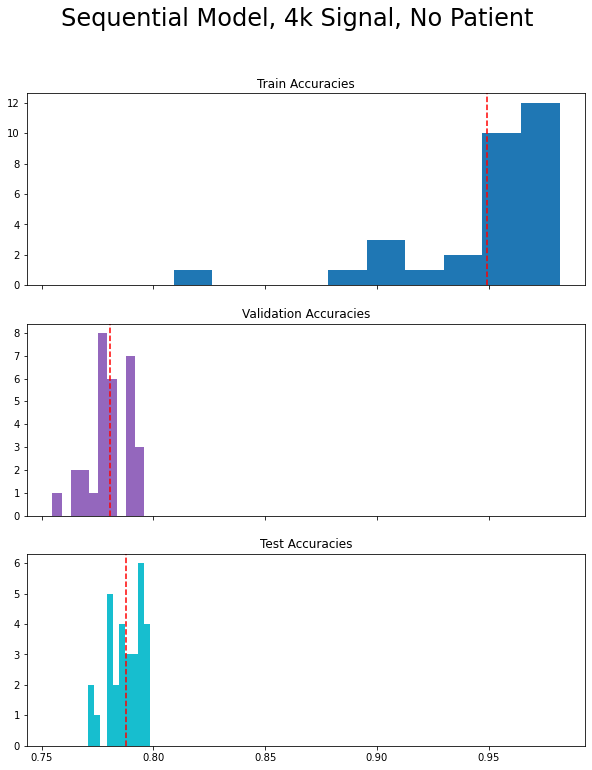

In [84]:
seq_4k_no_df = plot_accs_give_df('/model_eval_csv/Sequential Model, 4k Signal, No Patient.csv', 
                                 'Sequential Model, 4k Signal, No Patient')

In [52]:
p_r_f1('Sequential, 4K, No Pt', 21096, 444, 5307, 243)

    Sequential, 4K, No Pt
    ----------------------------------
    Precision: 0.3537117903930131
    Recall: 0.04378378378378378
    
    F1 Score: 0.07792207792207792
    


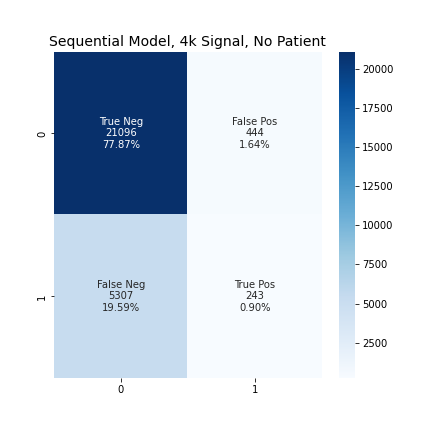

#### Interpretation

These clearly overfit to noise in the data. Train accuracies are strongly left skewed, nearly at 100% in most trials. Validation & Training accuracies are of a similar distribution, mean only slightly higher in the test set. 

### Sequential 1k, No Pt

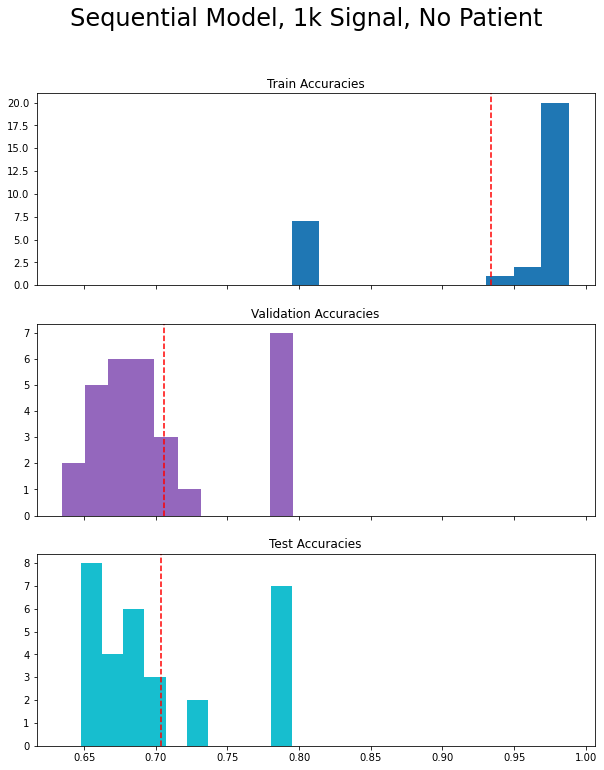

In [85]:
seq_1k_no_df = plot_accs_give_df('/model_eval_csv/Sequential Model, 1k Signal, No Patient.csv', 
                                 'Sequential Model, 1k Signal, No Patient')

In [54]:
p_r_f1('Sequential, 1K, No Pt', 18220, 3320, 4716, 834)

    Sequential, 1K, No Pt
    ----------------------------------
    Precision: 0.20077034183919115
    Recall: 0.15027027027027026
    
    F1 Score: 0.1718878812860676
    


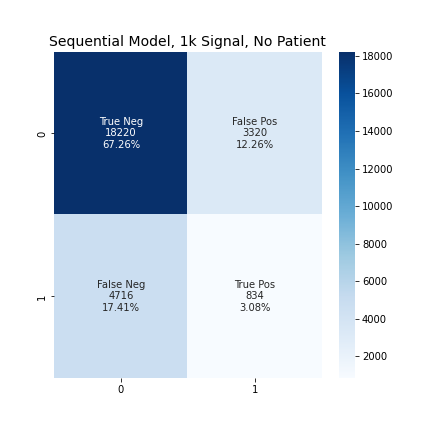

#### Interpretation

### Sequential 1k, With Pt

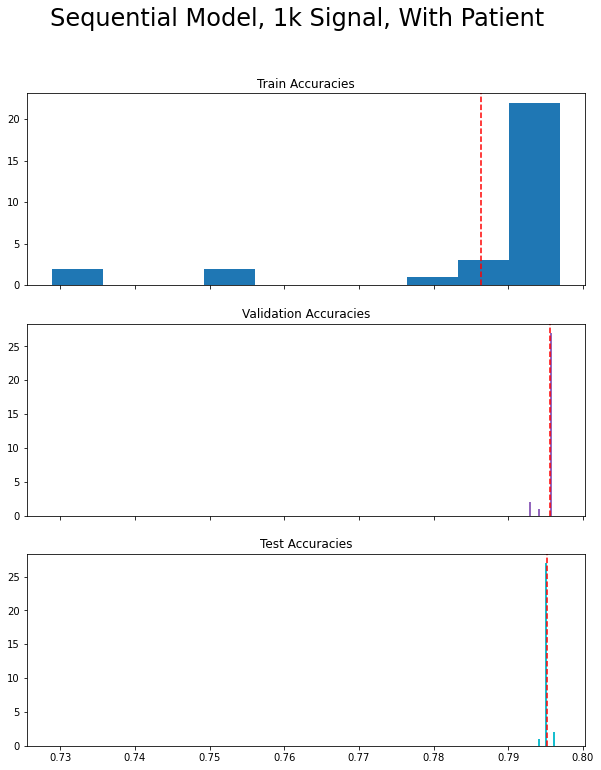

In [86]:
seq_1k_w_df = plot_accs_give_df('/model_eval_csv/Sequential Model, 1k Signal, With Patient.csv', 
                                 'Sequential Model, 1k Signal, With Patient')

In [56]:
p_r_f1('Sequential, 1K, With Pt', 21535, 5, 5544, 6)

    Sequential, 1K, With Pt
    ----------------------------------
    Precision: 0.5454545454545454
    Recall: 0.001081081081081081
    
    F1 Score: 0.0021578852724330154
    


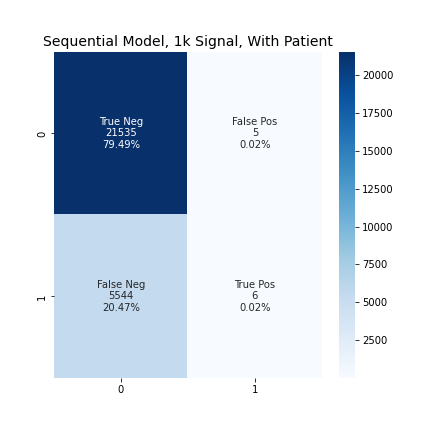

#### Interpretation

### Sequential MFCC, No Pt

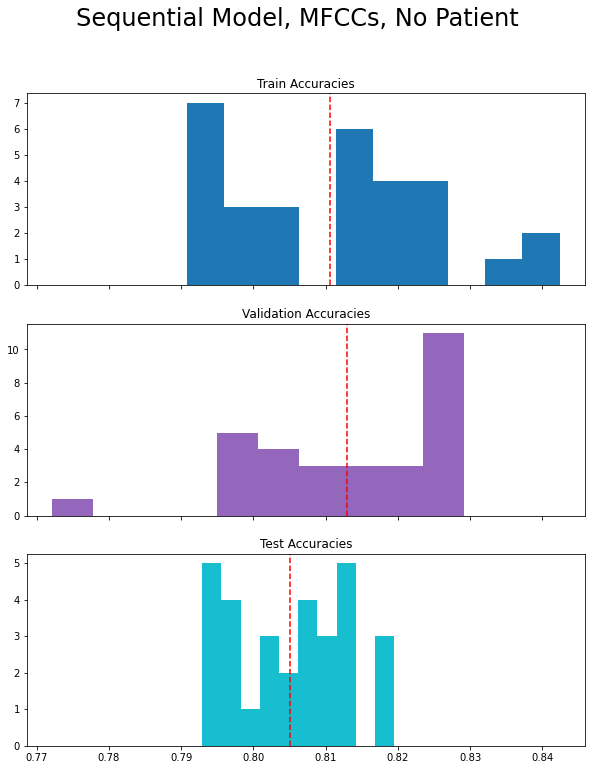

In [87]:
seq_MFCC_no_df = plot_accs_give_df('/model_eval_csv/Sequential Model, MFCCs, No Patient.csv', 
                                   'Sequential Model, MFCCs, No Patient')

In [58]:
p_r_f1('Sequential, MFCCs, No Pt', 21023, 517, 4762, 788)

    Sequential, MFCCs, No Pt
    ----------------------------------
    Precision: 0.6038314176245211
    Recall: 0.14198198198198198
    
    F1 Score: 0.2299051787016776
    


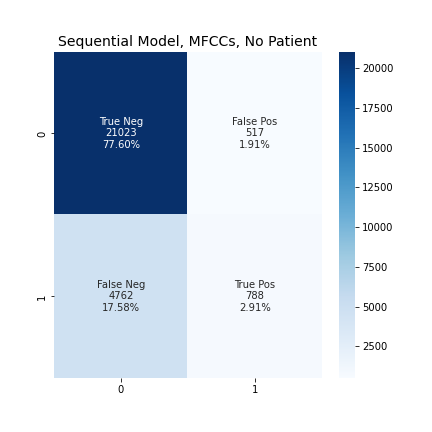

#### Interpretation

### Sequential MFCC, With Pt

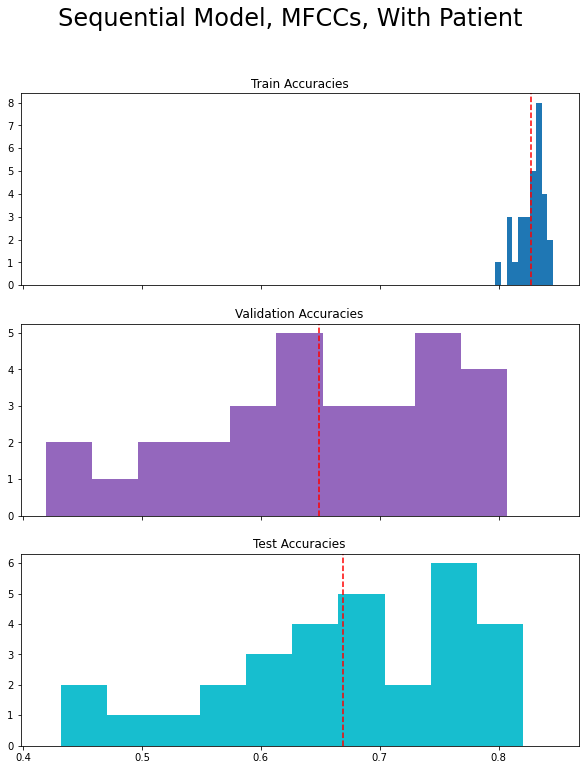

In [88]:
seq_MFCC_w_df = plot_accs_give_df('/model_eval_csv/Sequential Model, MFCCs, With Patient.csv', 
                                   'Sequential Model, MFCCs, With Patient')

In [60]:
p_r_f1('Sequential, MFCCs, With Pt', 14669, 6871, 2101, 3449)

    Sequential, MFCCs, With Pt
    ----------------------------------
    Precision: 0.3342054263565892
    Recall: 0.6214414414414414
    
    F1 Score: 0.43465658475110275
    


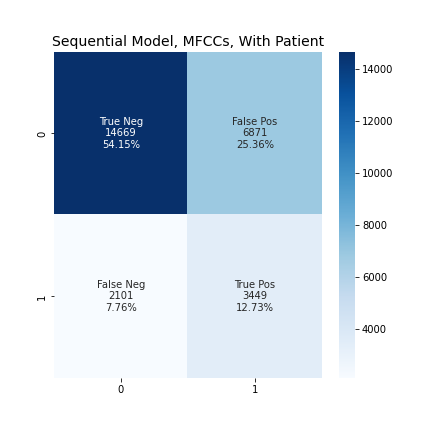

#### Interpretation

### CNN MFCC, No Pt

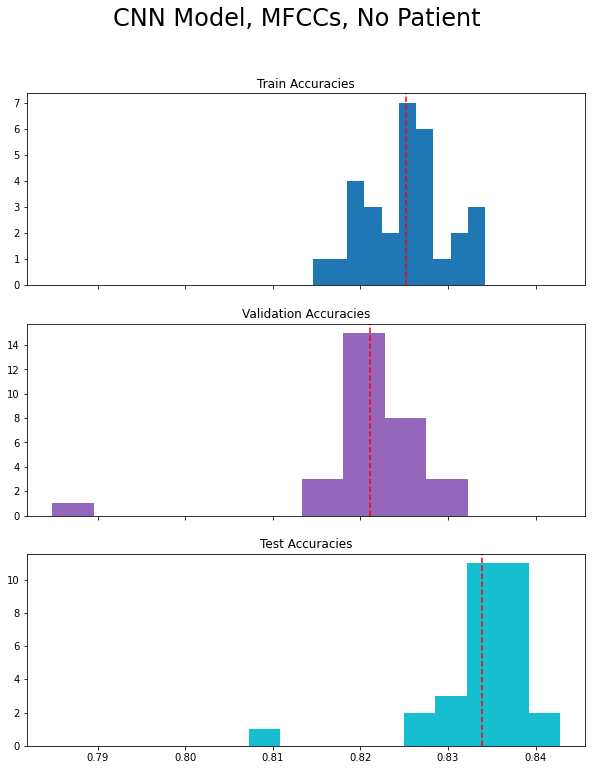

In [89]:
CNN_MFCC_no_df = plot_accs_give_df('/model_eval_csv/CNN Model, MFCCs, No Patient.csv', 
                                   'CNN Model, MFCCs, No Patient')

In [66]:
p_r_f1('CNN, MFCCs, No Pt', 21006, 534, 3967, 1583)

    CNN, MFCCs, No Pt
    ----------------------------------
    Precision: 0.7477562588568729
    Recall: 0.2852252252252252
    
    F1 Score: 0.41293856788835265
    


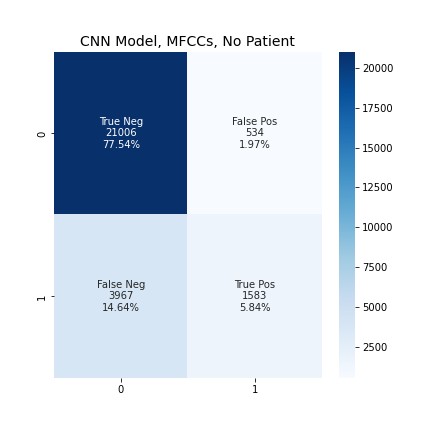

#### Interpretation

### CNN MFCC, With Pt

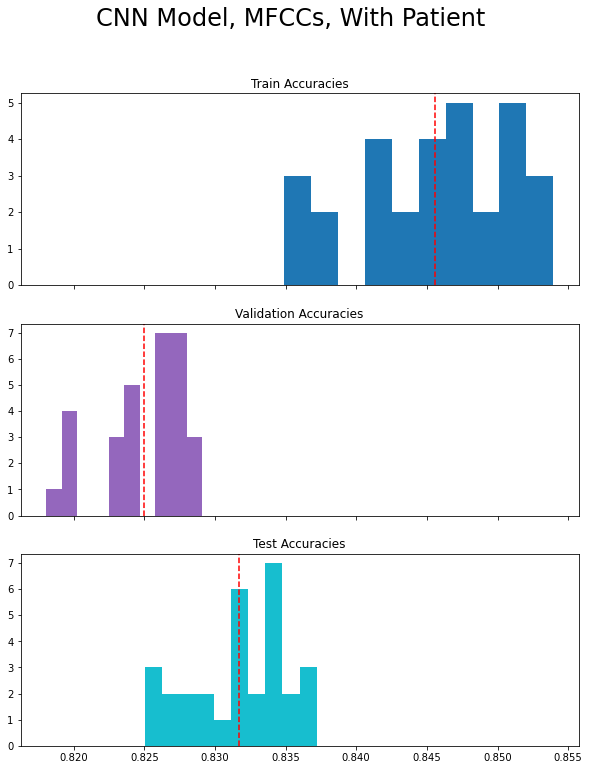

In [90]:
CNN_MFCC_w_df = plot_accs_give_df('/model_eval_csv/CNN Model, MFCCs, With Patient.csv', 
                                   'CNN Model, MFCCs, With Patient')

In [68]:
p_r_f1('CNN, MFCCs, With Pt', 20969, 571, 3989, 1561)

    CNN, MFCCs, With Pt
    ----------------------------------
    Precision: 0.7321763602251408
    Recall: 0.2812612612612613
    
    F1 Score: 0.4064045821400677
    


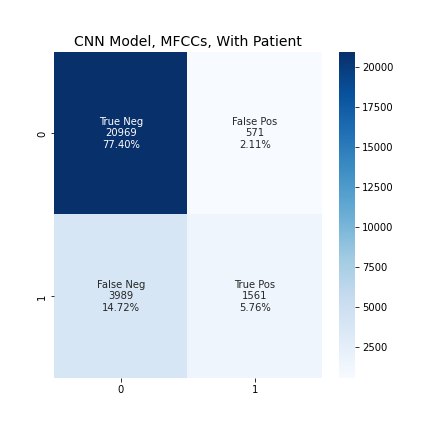

#### Interpretation

## Conclusions, and Other Interesting Comparisons